In [170]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, OPTICS, AgglomerativeClustering, KMeans
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

In [2]:
infile = 'tess_ode.pkl'
# infile = 'gaia2d_vecs.pkl'

In [3]:
data = pd.read_pickle(infile)

In [4]:
data = {k:v for k,v in data.items() if type(v) == np.ndarray}

In [63]:
clusters = 'random'

In [5]:
vecs = np.stack(list(data.values()))

In [6]:
vecs.shape

(39991, 40)

### DBSCAN

In [ ]:
alg = DBSCAN(min_samples=5, n_jobs=-1)
# alg = OPTICS(min_samples=10, n_jobs=-1, cluster_method='dbscan')
# alg = AgglomerativeClustering(n_clusters=10)
# alg = KMeans(n_clusters=20)

In [ ]:
clusters = alg.fit_predict(vecs)

In [ ]:
np.unique(clusters)

### TSNE

In [11]:
# res = pd.read_pickle('res.pkl')

In [26]:
tsne = TSNE(n_components=2, perplexity=80)

In [27]:
res = tsne.fit_transform(vecs)

In [28]:
pd.to_pickle(res, 'tess_tsne.pkl')

### TSNE Post Clustering

In [ ]:
res2 = pd.read_pickle('res.pkl')

In [ ]:
# res2 = np.copy(res)
res2 = res2

In [ ]:
x1s = res2[:,0]
x2s = res2[:,1]

In [ ]:
x1s = (x1s-x1s.min())/(x1s.max()-x1s.min())
x2s = (x2s-x2s.min())/(x2s.max()-x2s.min())

In [ ]:
res2[:,0] = x1s
res2[:,1] = x2s

In [ ]:
# alg = DBSCAN(min_samples=50, n_jobs=-1, algorithm='ball_tree')
# alg = OPTICS(min_samples=50, metric='minkowski', p=2, cluster_method='xi')
# alg = KMeans(n_clusters=10)

In [ ]:
# clusters2 = alg.fit_predict(res2)

In [ ]:
# clusters2.max()

### Summary

In [55]:
indir = 'tess/16_17/z_normalized/'
filenames = [indir+x+'.npy' for x in list(data.keys())]

In [61]:
clusters

In [67]:
# df = pd.DataFrame(zip(filenames, res2[:,0], res2[:,1], clusters),
#                   columns = ['file', 'x1', 'x2', 'cluster'])
# df = pd.DataFrame(zip(res[:,0], res[:,1], clusters),
#                   columns = ['x1', 'x2', 'cluster'])
if clusters == 'random':
    df = pd.DataFrame(zip(filenames, res[:,0], res[:,1]),
                      columns = ['file','x1', 'x2'])
    df['cluster'] = 'random'

(-68.01898020349572, 65.8851034029586, -68.95906383636057, 69.00979549529612)

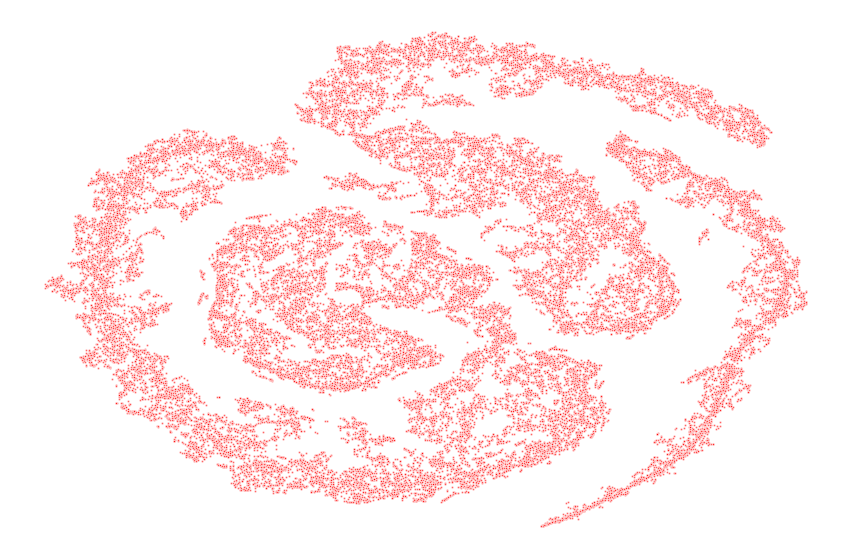

In [155]:
plt.figure(figsize=(15,10))
# sns.scatterplot(x='x1', y='x2', hue='cluster', data=df, 
#                 palette=sns.color_palette("Paired", df.cluster.nunique()))
ax=sns.scatterplot(x='x1', y='x2', data=df, s=5, alpha=0.6, color='r')
ax.axis('off')

### Random plots

In [70]:
import random

In [148]:
def plot_random(save=True):
    s = df.sample(n=1)
    file = s.file.values[0]
    cluster = s.cluster.values[0]
    entry = s.file
    x1 = s.x1.apply(lambda x: np.round(x,0)).values[0]
    x2 = s.x2.apply(lambda x: np.round(x,0)).values[0]
    outstr = str(cluster)+'_x1_'+str(x1)+'_x2_'+str(x2)
    data = np.load(file)[1]
    plt.figure(figsize=(5,5))
    #     ax.set_title('cluster: ' + str(ixs[i]) + '  ' + 'score: ' + str(probs[i]))
    ax=sns.lineplot(x=np.arange(len(data)), y=data, color='k', alpha=0.8)
    ax.set(yticks=[], xticks=[])
    if save:
        plt.savefig('tess_tsne/'+outstr+'.svg')
    return ax


In [151]:
# for _ in range(100):
#     plot_random()

### TS Stats / TSNE Hue

In [162]:
df['dip'] = 0
df['maximums'] = 0
df['max_fluctuation'] = 0
df['variance'] = 0

In [171]:
for row, value in tqdm(df.iterrows()):
    file = value['file']
    data = np.load(file)[1]
    # features
    dip = data.min()
    maxval = data.max()
    maxfluc = maxval-dip
    var = data.var()
    df.at[row, 'dip'] = dip
    df.at[row, 'maximums'] = maxval
    df.at[row, 'max_fluctuation'] = maxfluc
    df.at[row, 'variance'] = var

39991it [00:18, 2112.18it/s]


(-68.0208273734925, 65.8869505729554, -68.96155246977924, 69.01228412871478)

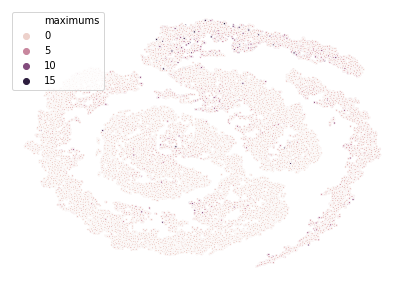

In [178]:
plt.figure(figsize=(7,5))
# sns.scatterplot(x='x1', y='x2', hue='cluster', data=df, 
#                 palette=sns.color_palette("Paired", df.cluster.nunique()))
ax=sns.scatterplot(x='x1', y='x2', data=df, s=5, alpha=1.0, hue='maximums')
ax.axis('off')

### Cluster plot

In [ ]:
samples = dict(df.groupby('cluster')['file'].apply(lambda x: random.choice(list(x))))

In [ ]:
d = {}
for cluster, file in samples.items():
    entry = df.loc[df['file'] == file]
    x1 = entry['x1'].apply(lambda x: np.round(x,0)).values[0]
    x2 = entry['x2'].apply(lambda x: np.round(x,0)).values[0]
    outstr = str(cluster)+'_x1_'+str(x1)+'_x2_'+str(x2)
    d[cluster] = np.load(file)[1]

In [ ]:
f, axes = plt.subplots(len(np.unique(clusters)),1, figsize=(4, 25), sharey=True)
for i in range(len(d)):
    if i == 0:
        continue
    ax = axes[i-1]
    ax.set_xticks(ticks=[])
    ax.set_yticks(ticks=[])
#     ax.set_title('cluster: ' + str(ixs[i]) + '  ' + 'score: ' + str(probs[i]))
    sns.lineplot(x=np.arange(len(d[i])), y=d[i], color='b', ax=ax)